In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import sklearn
import xgboost as xgb
import os
import time

In [2]:
for package in [sklearn,mlp,np,pd,xgb]:
    print(re.findall("([^']*)",str(package))[2],package.__version__)


sklearn 0.24.2
matplotlib 3.3.4
numpy 1.19.5
pandas 1.1.5
xgboost 1.5.2


In [3]:
#算法辅助 & 数据
import sklearn
from sklearn.model_selection import KFold, cross_validate
from sklearn.model_selection import train_test_split

#算法（单一学习器）
from sklearn.neighbors import KNeighborsClassifier as KNNC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.linear_model import LogisticRegression as LogiR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.naive_bayes import GaussianNB

#融合模型
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

In [8]:
# 根路径
file_ori =  'hog' + "\\"
# 原始图片文件夹路径
mask_wear_incorrect = 'mask_weared_incorrect'
mask_wear = 'with_mask'
mask_without = 'without_mask'

In [9]:
def getData(source, tag):
    num = os.listdir(source)  # num为list类型，存储着每张图片的名字
    for j in range(len(num)):
        k = np.load(file=source+'\\'+str(j) + ".npy", allow_pickle=True)
        X.append(k)
        y.append(tag)

In [ ]:
X = []
y = []
# 戴口罩标记为0 不戴为1 戴不对为2
getData(file_ori + mask_wear, 0)
getData(file_ori + mask_without, 1)
getData(file_ori + mask_wear_incorrect, 2)
X = np.array(X)
X = np.reshape(X, (X.shape[0], -1))
y = np.array(y)

In [13]:
X.shape

(2403, 8100)

In [14]:
np.unique(y)

array([0, 1, 2])

In [15]:
# random_state表示随机种子 使用同一个种子得到的划分结果是一样的
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.2, random_state=1412)

In [16]:
def fusion_estimators(clf):
    """
    对融合模型做交叉验证，对融合模型的表现进行评估
    """
    cv = KFold(n_splits=5,shuffle=True,random_state=1412)
    results = cross_validate(clf,Xtrain,Ytrain
                             ,cv = cv
                             ,scoring = "accuracy"
                             ,n_jobs = -1
                             ,return_train_score = True
                             ,verbose=False)
    test = clf.fit(Xtrain,Ytrain).score(Xtest,Ytest)
    print("train_score:{}".format(results["train_score"].mean())
          ,"\n cv_mean:{}".format(results["test_score"].mean())
          ,"\n test_score:{}".format(test)
         )

In [17]:
def individual_estimators(estimators):
    """
    对模型融合中每个评估器做交叉验证，对单一评估器的表现进行评估
    """
    for estimator in estimators:
        cv = KFold(n_splits=5,shuffle=True,random_state=1412)
        results = cross_validate(estimator[1],Xtrain,Ytrain
                             ,cv = cv
                             ,scoring = "accuracy"
                             ,n_jobs = -1
                             ,return_train_score = True
                             ,verbose=False)
        test = estimator[1].fit(Xtrain,Ytrain).score(Xtest,Ytest)
        print(estimator[0]
          ,"\n train_score:{}".format(results["train_score"].mean())
          ,"\n cv_mean:{}".format(results["test_score"].mean())
          ,"\n test_score:{}".format(test)
          ,"\n")

In [18]:
'''调节元学习器'''
#逻辑回归没有增加多样性的选项
clf1 = LogiR(max_iter = 3000, C=0.1, random_state=1412,n_jobs=5)
#增加特征多样性与样本多样性
clf2 = RFC(n_estimators= 100,max_features="sqrt",max_samples=0.9, random_state=1412,n_jobs=5)
#特征多样性，稍微上调特征数量
clf3 = GBC(n_estimators= 150,max_features=16,random_state=1412)

#增加算法多样性，新增决策树与KNN
clf4 = DTC(max_depth=16,random_state=1412)
clf5 = KNNC(n_neighbors=16,n_jobs=5)
clf6 = GaussianNB()

#新增随机多样性，相同的算法更换随机数种子
clf7 = RFC(n_estimators= 100,max_features="sqrt",max_samples=0.9, random_state=4869,n_jobs=5)
clf8 = GBC(n_estimators= 100,max_features=16,random_state=4869)

# 加入SVM
clf9 = sklearn.svm.SVC(C=0.28, kernel='rbf',random_state=1412,probability=True)

estimators = [("Logistic Regression",clf1),
              ("RandomForest", clf2),
              ("GBDT",clf3),
               ("Decision Tree", clf4),
              ("KNN",clf5),
              ("Bayes",clf6),
              ("RandomForest2", clf7), ("GBDT2", clf8),
              ("SVM", clf9)
             ]



In [19]:
final_estimator = LogiR(max_iter = 4000, C=5, random_state=420,n_jobs=5)
clf = StackingClassifier(estimators=estimators #level0的7个体学习器
                         ,final_estimator=final_estimator #level 1的元学习器
                         ,n_jobs=5)

# clf = VotingClassifier(estimators,voting="soft")

In [20]:
begin = time.time()
fusion_estimators(clf)

end = time.time()
print("running time:%d" %(end - begin))

train_score:1.0 
 cv_mean:0.9630668290043289 
 test_score:0.9667359667359667
running time:1879


In [ ]:
begin = time.time()
individual_estimators(estimators)

end = time.time()
print("running time:%d" %(end - begin))

Logistic Regression 
 train_score:0.9994797593474528 
 cv_mean:0.9464177489177491 
 test_score:0.9417879417879418 

RandomForest 
 train_score:1.0 
 cv_mean:0.9146685606060606 
 test_score:0.9272349272349273 

GBDT 
 train_score:0.9996098829648894 
 cv_mean:0.9443357683982685 
 test_score:0.9397089397089398 

KNN 
 train_score:0.9090776875222618 
 cv_mean:0.8917911255411255 
 test_score:0.8835758835758836 

Bayes 
 train_score:0.9197446091342043 
 cv_mean:0.88553841991342 
 test_score:0.8482328482328483 

RandomForest2 
 train_score:1.0 
 cv_mean:0.9172794913419914 
 test_score:0.9272349272349273 

GBDT2 
 train_score:0.9994797593474528 
 cv_mean:0.9302840909090909 
 test_score:0.9251559251559252 



In [21]:
# save model
import joblib
joblib.dump(clf, 'dst_model.pkl')

['dst_model.pkl']

In [4]:
# 481个测试样例
confusion_mat = np.zeros((3, 3)) # 三分类混淆矩阵 y:real_label x:pred_label
idx = 0
pred_label = clf.predict(Xtest)
for (pred, real) in zip(pred_label, Ytest):
    confusion_mat[real, pred] = confusion_mat[real, pred] + 1
confusion_mat

NameError: name 'clf' is not defined

In [ ]:
# 画热图
datas = np.log(1 + confusion_mat)  # 防止0
ax = plt.subplot()
x_tick = ['with', 'without', 'incorrect']
y_tick = ['with', 'without', 'incorrect']
im = ax.imshow(datas, cmap='binary')  #绘制 可通过更改cmap改变颜色
ax.set_xticks(np.arange(len(x_tick)), labels=x_tick)  #设置标签
ax.set_yticks(np.arange(len(y_tick)), labels=y_tick)
plt.colorbar(im)
plt.gcf().savefig("hot.svg", dpi=300)
plt.show()

In [ ]:
(R, P) = (0, 0)
for idx in range(3):
    P = P + confusion_mat[idx, idx] / sum(confusion_mat[:, idx])
    R = R + confusion_mat[idx, idx] / sum(confusion_mat[idx, :])
(R, P) = (R / 3, P / 3)
F1 = 2 * R * P / (P + R)
print("P={}, R={}, F1={}".format(P, R, F1))

In [ ]:
# 绘制模型比较直方图
name_list = ['Logistic','RandomForest_1','GBDT','Decision Tree', 'KNN', 'Bayes',
             'RandomForest_2', 'GBDT_2', 'SVM', 'voting', 'Stacking']
num_list_1 = [0.999479, 1.0,      0.999609, 1.0,      0.909077, 0.919744, 1.0,      0.999479,
              0.959677, 0.999869, 1.0]
num_list_2 = [0.946417, 0.914668, 0.944335, 0.716961, 0.891791, 0.885538, 0.917279, 0.930284,
              0.914673, 0.942251, 0.962550]
num_list_3 = [0.941787, 0.927234, 0.939708, 0.690228, 0.883575, 0.848232, 0.927234, 0.925155,
              0.902286, 0.931392, 0.966735]

x = list(range(0, 8 * len(name_list), 8))
total_width, n = 6, 3
width = total_width / n

fig = plt.figure(figsize=(16, 8))    # 设置画布大小
plt.bar(x, num_list_1, width=width, label='train_score',fc = 'y')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, num_list_2, width=width, label='cv_mean',tick_label = name_list,fc = 'g')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, num_list_3, width=width, label='test_score',tick_label = name_list,fc = 'k')
plt.legend()
plt.ylim(0.825, 1)
y_1 = max(num_list_2)
y_2 = max(num_list_3)
plt.axhline(y=y_1, color='r', linestyle='-')
plt.axhline(y=y_2, color='bxQxQ', linestyle='-')
plt.show()

In [5]:
# 单图片分类效果
def classifyImg(fileName):
    import cv2
    from HogExtract import Hog_descriptor
    img = cv2.imread(fileName, cv2.IMREAD_COLOR)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hog = Hog_descriptor(gray, cell_size=8, bin_size=9)
    vector, _ = hog.extract()
    vector = np.array(vector).reshape((1, -1))
    label_pred = clf.predict(vector)
    # 戴口罩标记为0 不戴为1 戴不对为2
    if label_pred == 0:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
        plt.title('口罩佩戴正确')
        plt.show()
        print("戴口罩")
    elif label_pred == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
        plt.title('没戴口罩')
        plt.show()
        print("没戴口罩")
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
        plt.title('口罩佩戴不正确')
        plt.show()
        print("口罩佩戴不正确")

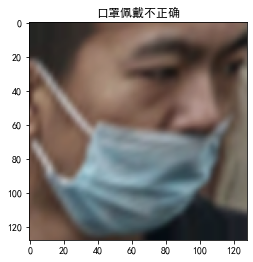

口罩佩戴不正确
running time:1265


In [8]:
import joblib
clf = joblib.load('dst_model.pkl')
begin = time.time()
classifyImg('data\\mask_weared_incorrect\\201.png')

end = time.time()
print("running time:%d" %(round((end - begin) * 1000)))